In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
import seaborn as sn

mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
BATCH_SIZE = 64
MAX_EPOCHS = 20
STEPS_PER_EPOCH = 1000
VALIDATION_STEPS = 100
INUPT_WIDTH = 24
LABEL_WIDTH = 1
STRIDE_WIDTH = 1
BUFFER_SIZE = 10000

# PS: Try to provide and fork dataset from this links
# https://drive.google.com/file/d/1-2qi4aEYeMuvESgPemzWUgRhwZwmMOE8/view
# https://drive.google.com/file/d/1-1k5W0hhJPCt7Kaxrw6ECsYcWxCiMdt7/view

BITSTAMP_CSV = '/content/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip'
COINBASE_CSV = '/content/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip'
     

In [4]:
bitstamp_df = pd.read_csv(BITSTAMP_CSV)
coinbase_df = pd.read_csv(COINBASE_CSV)

In [5]:
bitstamp_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Timestamp,4363457.0,1.456469e+09,7.573296e+07,1.325318e+09,1.390770e+09,1.456610e+09,1.522062e+09,1.587514e+09
Open,3126480.0,3.674656e+03,3.935578e+03,3.800000e+00,4.100000e+02,1.175140e+03,6.931175e+03,1.966576e+04
High,3126480.0,3.677366e+03,3.939077e+03,3.800000e+00,4.102400e+02,1.175770e+03,6.935780e+03,1.966600e+04
Low,3126480.0,3.671730e+03,3.931713e+03,1.500000e+00,4.098300e+02,1.174825e+03,6.926790e+03,1.964996e+04
Close,3126480.0,3.674595e+03,3.935490e+03,1.500000e+00,4.100000e+02,1.175140e+03,6.931225e+03,1.966575e+04
Volume_(BTC),3126480.0,9.855040e+00,3.229272e+01,0.000000e+00,3.988120e-01,1.990000e+00,7.639098e+00,5.853852e+03
Volume_(Currency),3126480.0,2.884459e+04,1.010277e+05,0.000000e+00,3.503759e+02,2.620491e+03,1.760057e+04,7.569437e+06
Weighted_Price,3126480.0,3.674570e+03,3.935458e+03,3.800000e+00,4.099998e+02,1.175200e+03,6.931180e+03,1.966330e+04


In [6]:
bitstamp_df.isna().sum()

Timestamp                  0
Open                 1236977
High                 1236977
Low                  1236977
Close                1236977
Volume_(BTC)         1236977
Volume_(Currency)    1236977
Weighted_Price       1236977
dtype: int64

In [7]:
df = bitstamp_df.ffill()
df.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [8]:
date_time = pd.to_datetime(df.pop('Timestamp'), unit='s')

In [9]:
df = df[8::60]
date_time = date_time[8::60]

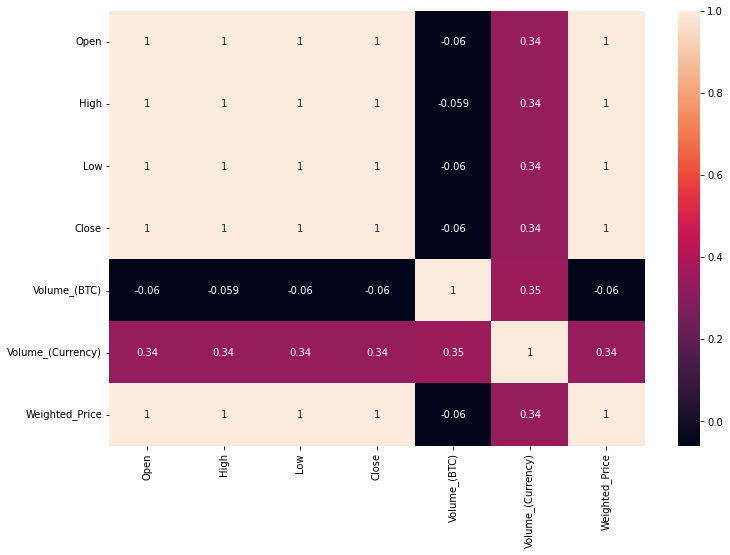

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sn.heatmap(correlation_matrix, annot=True)
plt.show()

In [11]:
df.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)

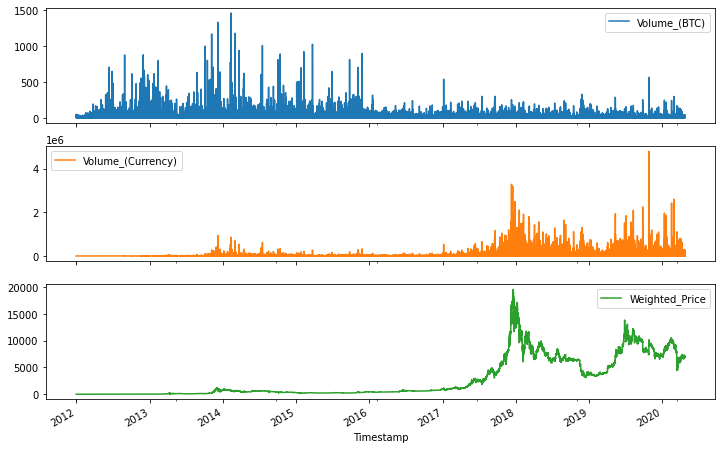

In [12]:
plot_cols = df.columns.to_list()
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [13]:
n = len(df)
train_split = int(n * 0.8)

train_df = df[:train_split]
valid_df = df[train_split:]

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std

In [15]:
def split_window(dataframe):
  input_slice = slice(0, INUPT_WIDTH)
  labels_slice = slice(INUPT_WIDTH, None)

  inputs = dataframe[:, input_slice, :]
  labels = dataframe[:, labels_slice, :]

  labels = labels[:, :, -1:]

  inputs.set_shape([None, INUPT_WIDTH, None])
  labels.set_shape([None, LABEL_WIDTH, None])

  return inputs, labels

In [16]:
def make_dataset(data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=INUPT_WIDTH + LABEL_WIDTH,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE
  )


  ds = ds.map(split_window)

  return ds

In [17]:
train_ds = make_dataset(train_df)
valid_ds = make_dataset(valid_df)

In [18]:
def compile_and_fit(model, train_ds, valid_ds, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min'
  )

  model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stopping]
  )
  return history

In [19]:
lstm_model = K.models.Sequential([
    K.layers.LSTM(64, return_sequences=False),
    K.layers.Dense(units=1)
])

In [20]:
history = compile_and_fit(lstm_model, train_ds, valid_ds)

Epoch 1/20
909/909 [==============================] - 26s 25ms/step - loss: 0.0107 - mean_absolute_error: 0.0260 - val_loss: 0.0024 - val_mean_absolute_error: 0.0391
Epoch 2/20
909/909 [==============================] - 22s 24ms/step - loss: 7.0693e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0014 - val_mean_absolute_error: 0.0270
Epoch 3/20
909/909 [==============================] - 21s 23ms/step - loss: 6.2976e-04 - mean_absolute_error: 0.0110 - val_loss: 8.1901e-04 - val_mean_absolute_error: 0.0159
Epoch 4/20
909/909 [==============================] - 21s 24ms/step - loss: 5.6009e-04 - mean_absolute_error: 0.0105 - val_loss: 8.9289e-04 - val_mean_absolute_error: 0.0192
Epoch 5/20
909/909 [==============================] - 21s 24ms/step - loss: 5.3078e-04 - mean_absolute_error: 0.0102 - val_loss: 6.5649e-04 - val_mean_absolute_error: 0.0136
Epoch 6/20
909/909 [==============================] - 22s 24ms/step - loss: 4.5383e-04 - mean_absolute_error: 0.0093 - val_loss: 9.4769e-04 - 

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


2/2 [==============================] - 0s 14ms/step


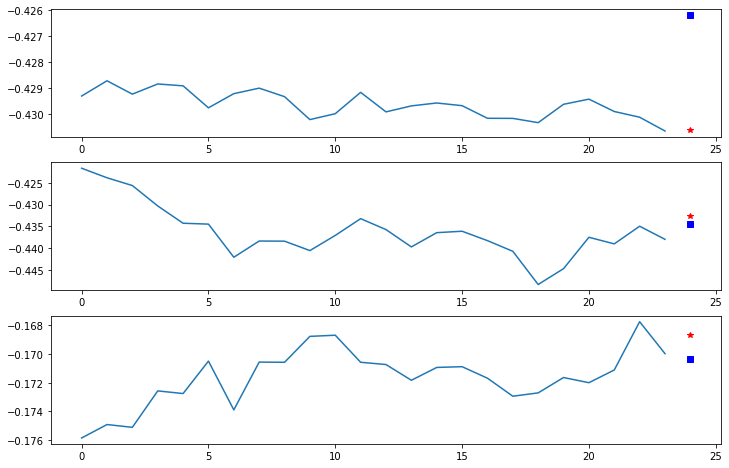

In [22]:
for b, (x, y) in enumerate(train_ds.take(3)):
  plt.subplot(3, 1, b+1)
  plt.plot(list(range(24)), x[b, :, -1])
  plt.plot(24, y[b].numpy(), 'r*')
  plt.plot(24, lstm_model.predict(x)[b], 'bs')